In [1]:
from io import BytesIO
import boto3
import multiprocessing as mp
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def load_data_from_s3(filename, format='csv'):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket='loan-analysis-data', Key=filename)
    data = obj['Body'].read()
    f = BytesIO(data)
    if format=='csv':
        df = pd.read_csv(f, low_memory=False)
    if format=='pkl.bz2':
        df = pd.read_pickle(f, compression='bz2')
    return df    

In [69]:
# Read in loan ROIs
with open('data/loan_rois.pickle', 'rb') as handle:
    loan_rois = pickle.load(handle)

In [2]:
# Read in training data
training_loans = pd.read_pickle('data/cleaned_training_loans.pkl.bz2')

# Read in testing data
testing_loans = pd.read_pickle('data/cleaned_testing_loans.pkl.bz2')

In [3]:
training_loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,roi
id,,,,,,,,,,,,,,,,,,,,,
1077501,5000.0,10.650000,162.869995,10.0,24000.0,2011-12-01,27.65,0,735.0,739.0,...,0,0,0,0,0,0,0,0,0,10.289307
1077175,2400.0,15.960000,84.330002,10.0,12252.0,2011-12-01,8.72,0,735.0,739.0,...,0,0,0,0,0,0,1,0,0,16.248779
1076863,10000.0,13.490000,339.309998,10.0,49200.0,2011-12-01,20.00,0,690.0,694.0,...,0,0,0,0,1,0,0,0,0,13.707275
1075269,5000.0,7.900000,156.460007,3.0,36000.0,2011-12-01,11.20,0,730.0,734.0,...,0,0,0,0,0,0,0,0,1,7.783084
1072053,3000.0,18.639999,109.430000,9.0,48000.0,2011-12-01,5.35,0,660.0,664.0,...,0,0,0,0,0,0,0,0,0,19.114990


In [4]:
testing_loans.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
id,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,13.990000,123.029999,10.0,55000.0,2015-12-01,5.910000,0,675.0,679.0,...,0,0,0,0,0,0,0,0,0,0
68495092,8650.0,19.889999,320.989990,8.0,55000.0,2015-12-01,25.490000,0,675.0,679.0,...,0,0,0,0,0,0,0,0,0,0
68466961,28000.0,6.490000,858.049988,10.0,92000.0,2015-12-01,21.600000,0,720.0,724.0,...,0,0,0,0,0,0,0,0,0,0
68466916,25000.0,7.490000,777.549988,10.0,109000.0,2015-12-01,26.020000,0,745.0,749.0,...,0,0,0,0,0,0,0,0,0,0
68354783,9600.0,7.490000,298.579987,8.0,60000.0,2015-12-01,22.440001,0,695.0,699.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
training_loans.index[:10]

Int64Index([1077501, 1077175, 1076863, 1075269, 1072053, 1069908, 1064687,
            1069866, 1069057, 1069759],
           dtype='int64', name='id')

In [6]:
training_loans['roi'].head()

id
1077501    10.289307
1077175    16.248779
1076863    13.707275
1075269     7.783084
1072053    19.114990
Name: roi, dtype: float64

In [79]:
roi_col = pd.DataFrame.from_dict(loan_rois, orient='index')
roi_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529507 entries, 1077501 to 36271262
Data columns (total 1 columns):
0    529507 non-null float64
dtypes: float64(1)
memory usage: 8.1 MB


In [80]:
roi_col.head()

,0
1077501,10.289307
1077175,16.248779
1076863,13.707275
1075269,7.783084
1072053,19.114990


In [81]:
training_loans['roi'] = roi_col
training_loans['roi'].head(10)

id
1077501    10.289307
1077175    16.248779
1076863    13.707275
1075269     7.783084
1072053    19.114990
1069908    12.606201
1064687   -97.884317
1069866     9.896030
1069057   -30.444461
1069759    16.585693
Name: roi, dtype: float64

In [91]:
training_loans.index = training_loans.index.astype(int)

In [92]:
training_loans.index

Int64Index([ 1077501,  1077175,  1076863,  1075269,  1072053,  1069908,
             1064687,  1069866,  1069057,  1069759,
            ...
            36231718, 36381704, 36421485, 35094480, 36260758, 36221446,
            36330911, 36371250, 36441262, 36271262],
           dtype='int64', name='id', length=529507)

In [93]:
training_loans['roi'] = roi_col
training_loans['roi'].head(10)

id
1077501    10.289307
1077175    16.248779
1076863    13.707275
1075269     7.783084
1072053    19.114990
1069908    12.606201
1064687   -97.884317
1069866     9.896030
1069057   -30.444461
1069759    16.585693
Name: roi, dtype: float64

In [98]:
training_loans.loc[10119623]['roi']

11.944580078124998

In [ ]:
pd.read_pickle('data/cleaned_training_loans.pkl.bz2')

In [99]:
training_loans.to_pickle('data/cleaned_training_loans_indexed.pkl.bz2', compression='bz2')

In [58]:
testing_loans.set_index('id', inplace=True)
testing_loans.head(5)

,loan_amnt,int_rate,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
id,,,,,,,,,,,,,,,,,,,,,
68407277,3600,13.990000,123.029999,10.0,55000.0,2015-12-01,5.910000,0,675.0,679.0,...,0,0,0,0,0,0,0,0,0,0
68495092,8650,19.889999,320.989990,8.0,55000.0,2015-12-01,25.490000,0,675.0,679.0,...,0,0,0,0,0,0,0,0,0,0
68466961,28000,6.490000,858.049988,10.0,92000.0,2015-12-01,21.600000,0,720.0,724.0,...,0,0,0,0,0,0,0,0,0,0
68466916,25000,7.490000,777.549988,10.0,109000.0,2015-12-01,26.020000,0,745.0,749.0,...,0,0,0,0,0,0,0,0,0,0
68354783,9600,7.490000,298.579987,8.0,60000.0,2015-12-01,22.440001,0,695.0,699.0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
testing_loans.to_pickle('data/cleaned_testing_loans.pkl.bz2', compression='bz2')

In [61]:
payments = load_data_from_s3('cleaned_payments_data.pkl.bz2', format='pkl.bz2')

In [62]:
payments.head()

,LOAN_ID,RECEIVED_D,RECEIVED_AMT_INVESTORS,PBAL_END_PERIOD_INVESTORS,mths_since_issue
0,54734,2009-09-01,632.770996,18636.410156,1
1,54734,2009-10-01,632.770996,18188.363281,2
2,54734,2009-11-01,632.770996,17735.876953,3
3,54734,2009-12-01,632.770996,17278.906250,4
4,54734,2010-01-01,632.770996,16817.404297,5


In [71]:
test = payments.set_index(['RECEIVED_D', 'LOAN_ID'])
test.head()

,,RECEIVED_AMT_INVESTORS,PBAL_END_PERIOD_INVESTORS,mths_since_issue
RECEIVED_D,LOAN_ID,,,
2009-09-01,54734,632.770996,18636.410156,1
2009-10-01,54734,632.770996,18188.363281,2
2009-11-01,54734,632.770996,17735.876953,3
2009-12-01,54734,632.770996,17278.906250,4
2010-01-01,54734,632.770996,16817.404297,5


In [74]:
from datetime import datetime

In [93]:
test.loc[datetime(2007,7,1)]

,RECEIVED_AMT_INVESTORS,PBAL_END_PERIOD_INVESTORS,mths_since_issue
LOAN_ID,,,
72176,7.189307,219.559830,1
73582,7.289357,219.637436,1
74505,7.256250,219.611313,1
77792,3.975833,121.962997,1
81085,9.032310,268.539795,1
81085,9.032310,262.019165,1
83185,19.331249,609.375916,1
83489,18.119135,560.896790,1
83979,7.769166,243.779495,1


In [98]:
test[['RECEIVED_AMT_INVESTORS', 'PBAL_END_PERIOD_INVESTORS']].head()

,,RECEIVED_AMT_INVESTORS,PBAL_END_PERIOD_INVESTORS
RECEIVED_D,LOAN_ID,,
2009-09-01,54734,632.770996,18636.410156
2009-10-01,54734,632.770996,18188.363281
2009-11-01,54734,632.770996,17735.876953
2009-12-01,54734,632.770996,17278.906250
2010-01-01,54734,632.770996,16817.404297


In [96]:
test.to_pickle('data/cleaned_payments_data_indexed.pkl.bz2', compression='bz2')

# Begin Modeling Testing

In [8]:
from io import BytesIO
import boto3
import multiprocessing as mp
import pickle
import pandas as pd
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

def load_data_from_s3(filename, format='csv'):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket='loan-analysis-data', Key=filename)
    data = obj['Body'].read()
    f = BytesIO(data)
    if format=='csv':
        df = pd.read_csv(f, low_memory=False)
    if format=='pkl.bz2':
        df = pd.read_pickle(f, compression='bz2')
    return df

%run src/portfolio.py
%run src/modeling.py

### Modeling.py

In [75]:
# Code to start training and testing a model once the data has been cleaned.
import pandas as pd

def split_data_into_labels_and_target(df):
    X = df.drop(['roi', 'issue_d'], axis=1)
    y = df['roi']
    return X, y

def get_training_and_testing_data(df, split_date='2015-09-01'):
    '''
    Loans before the cutoff date will be used for training the model, the others will be used for
    simulating and evaluating the model's performance.
    '''
    training_loans = df[df['issue_d'].isin(pd.date_range('2005-01-01', split_date)) == True]
    testing_loans = df[df['issue_d'].isin(pd.date_range('2005-01-01', split_date)) == False]
    return training_loans, testing_loans

def train_model(model, X_train, y_train):
    fit_model = model.fit(X_train, y_train)
    return fit_model

def get_predictions(fit_model, X):
    return fit_model.predict(X)

def create_dataframe_for_simulation(loan_df, predictions):
    simulation_df = loan_df.copy(deep=True)
    simulation_df['predicted_roi'] = predictions
    return simulation_df[['issue_d', 'loan_amnt', 'predicted_roi']]

### Portfolio.py

In [10]:
from dateutil.relativedelta import relativedelta

class Loan:
    def __init__(self, loan_id, borrowed_amount, investment_amount):
            self.id = loan_id
            self.size = borrowed_amount
            self.initial_investment = min(investment_amount, borrowed_amount)
            self.principal_balance = min(investment_amount, borrowed_amount)
            self.status = 'Current'
            self.months_since_last_payment = 0
    
    def default(self):
        self.status = 'Default'
        self.principal_balance = 0

    def update_investment_principal_balance(self, overall_principal):
        self.principal_balance = (self.initial_investment / self.size) * overall_principal

class Portfolio:
    def __init__(self, starting_balance, investment_per_loan, start_date, min_roi=5.0):
        self.active_loans = []
        self.defaulted_loans = []
        self.cash_balance = starting_balance
        self.invested_principal_balance = 0
        self.investment_per_loan = investment_per_loan
        self.date = start_date
        self.min_roi = min_roi

    def update_invested_principal_balance(self):
        self.invested_principal_balance = sum([loan.principal_balance for loan in self.active_loans])

    def increment_date_by_one_month(self):
        self.date += relativedelta(months=1)

    def purchase_loans(self, loans):
        for loan in loans:
            self.active_loans.append(loan)

    def convert_df_rows_to_loans(self, df):
        loans = []
        rows = df.to_dict(orient='records')
        for row in rows:
            loans.append(Loan(row['id'], row['loan_amnt'], self.investment_per_loan))
        return loans

    def get_loans_available_for_given_date(self, loans_df):
        '''
        date parameter needs to be of type datetime.date
        '''
        return loans_df[(loans_df['issue_d'].dt.year == self.date.year) & (loans_df['issue_d'].dt.month == self.date.month)]

    def get_top_n_loans_to_buy(self, loans, n):
        loans.sort_values(by='predicted_roi', ascending=False, inplace=True)
        return loans.head(n)

    def get_loans_over_required_roi_threshold(self, df, min_roi):
        return df[df['predicted_roi'] >= min_roi]

    def get_payments_for_date(self, payments_df, date):
        '''
        date parameter needs to be of type datetime.date
        '''
        return payments_df[(payments_df['RECEIVED_D'].dt.year == date.year) & (payments_df['RECEIVED_D'].dt.month == date.month)]

    def get_top_n_loans_to_buy(loans, n):
        loans.sort_values(by='predicted_roi', ascending=False, inplace=True)
        return loans.head(n)

    def add():
        pass


In [53]:
training_loans = pd.read_pickle('data/cleaned_training_loans.pkl.bz2')
testing_loans = pd.read_pickle('data/cleaned_testing_loans.pkl.bz2')

In [55]:
training_loans['issue_d'].min()

Timestamp('2007-06-01 00:00:00')

In [76]:
# Only include the loans beginning in 2010.
training_loans = training_loans[training_loans['issue_d'].isin(pd.date_range('2010-01-01', '2019-01-01')) == True]
training_loans.to_pickle('data/cleaned_training_loans_.pkl.bz2', compression='bz2')

In [77]:
len(training_loans)

522991

In [78]:
X_train, y_train = split_data_into_labels_and_target(training_loans)

In [79]:
X_test = testing_loans.drop(columns='issue_d')
X_test.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
id,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,13.990000,123.029999,10.0,55000.0,5.910000,0,675.0,679.0,1,...,0,0,0,0,0,0,0,0,0,0
68495092,8650.0,19.889999,320.989990,8.0,55000.0,25.490000,0,675.0,679.0,4,...,0,0,0,0,0,0,0,0,0,0
68466961,28000.0,6.490000,858.049988,10.0,92000.0,21.600000,0,720.0,724.0,0,...,0,0,0,0,0,0,0,0,0,0
68466916,25000.0,7.490000,777.549988,10.0,109000.0,26.020000,0,745.0,749.0,1,...,0,0,0,0,0,0,0,0,0,0
68354783,9600.0,7.490000,298.579987,8.0,60000.0,22.440001,0,695.0,699.0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
from xgboost import XGBRegressor
model = XGBRegressor(n_jobs=-1)
fit_model = train_model(model, X_train, y_train)
#test_predictions = get_predictions(fit_model, X_test)

In [81]:
train_predictions = fit_model.predict(X_train)

In [82]:
test_predictions = fit_model.predict(X_test)
test_predictions

array([  6.8195233, -12.377034 ,   5.547388 , ...,   3.8532567,
         3.863252 ,   4.315468 ], dtype=float32)

In [83]:
payments = load_data_from_s3('cleaned_payments_data_indexed.pkl.bz2', format='pkl.bz2')

In [84]:
X_test['predicted_roi'] = test_predictions

In [85]:
copy_training = X_train.copy(deep=True)
copy_testing = X_test.copy(deep=True)

In [86]:
copy_training['predicted_roi'] = train_predictions
copy_testing['predicted_roi'] = test_predictions

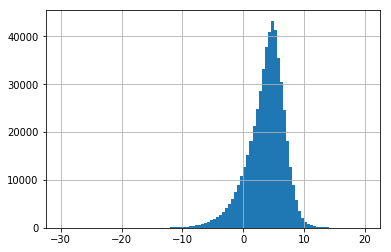

In [87]:
copy_training['predicted_roi'].hist(bins=100)

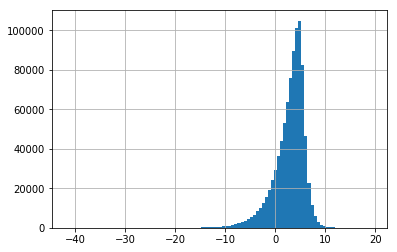

In [88]:
copy_testing['predicted_roi'].hist(bins=100)

In [71]:
simulation_df = create_dataframe_for_simulation(testing_loans, test_predictions)
simulation_df.groupby(['issue_d'], as_index=False).agg(['mean'])

,loan_amnt,predicted_roi
,mean,mean
issue_d,,
2015-10-01,12814.418945,2.488757
2015-11-01,12716.450195,2.490915
2015-12-01,12616.103516,2.328381
2016-01-01,13836.963867,2.479807
2016-02-01,13663.027344,2.752627
2016-03-01,13265.534180,2.180207
2016-04-01,13019.642578,2.760967
2016-05-01,12930.120117,2.606421


In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
copy_testing.predicted_roi.max()

19.219366

In [97]:
simulation_df.issue_d.min()

Timestamp('2015-10-01 00:00:00')

In [99]:
simulation_df.head()

,issue_d,loan_amnt,predicted_roi
id,,,
68407277,2015-12-01,3600.0,6.819523
68495092,2015-12-01,8650.0,-12.377034
68466961,2015-12-01,28000.0,5.547388
68466916,2015-12-01,25000.0,4.509906
68354783,2015-12-01,9600.0,4.441494


In [104]:
simulation_df = simulation_df.reset_index(level=0).set_index('issue_d')

In [105]:
simulation_df.to_pickle('data/test_predictions_xgb.pkl.bz2', compression='bz2')